# Лабораторная работа №5 по курсу "Технологии машинного обучения"
### Горбатнко И.А. ИУ5-64



## 1) Набор данных для решения задачи классификации или регрессии

В качестве набора данных возьмем базу данных наблюдаемых пациентов с возможным сердечно-сосудистым заболеванием. База состоит из 14 атрибутов:
- age - возраст пациента
- gender - пол пациента (0 или 1)
- chest_pain_type - тип боли в груди (значения от 0 до 3)
- blood_pressure - кровяное давление в состоянии покоя в мм.рт.ст.
- cholestoral - количество холестерина в мг/дл
- sugar - количество сахара в крови (1, если >120мг/дл, 0, если <=120мг/дл)
- ECG - электрокардиографические результаты в состоянии покоя (значения от 0 до 2)
- max_heart_rate - максимальное зафиксированное значение пульса
- stenocardia - наличие стенокардии или ее отсутствие после физической нагрузки (0 или 1)
- ST_depression - депрессия ST, вызванная физической нагрузкой относительно покоя
- slope - наклон пикового значения ST при нагрузке (от 0 до 2)
- vessels - количество крупных сосудов, показанных на флюороскопии (от 0 до 3)
- thal - 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект
- target - наличие или отсутствие сердечно-сосудистого заболевания у пациента (1 или 0)

Конечной целью (target) является значение 0 или 1 (соответственно отсутствие сердечно-сосудистого заболевания или его наличие). 
Будем решать задачу классификации и задачу регрессии. В качестве целевого признака для решения задачи классификации будем использовать "target". "target" принимает значения только 0 или 1, значит это задача бинарной классификации. 
В качестве целевого признака для решения задачи регресии будем использовать "max_heart_rate".
Датасет состоит из одного файла "Heart_Desease.csv", содержащий 303 строки.

**Импортируем библиотеки:**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from gmdhpy import gmdh
%matplotlib inline 
sns.set(style="ticks")


**Отрисовка ROC-кривой:**
    

In [2]:
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## 2) Разделение выборки на обучающую и тестовую

**Поскольку у нас изначльно один файл датасета, напишем функцию split, деляющую csv-файл на куски и разделим наш датасет Heart_Desease.csv из 303 строк на два датасета: Heart_Desease_Train.csv из 212 строк - обучающая выборка, и Heart_Desease_Test.csv из 91 строки - тестовая выборка.**

In [3]:
def split(filehandler, delimiter=',', row_limit=212,
          output_name_template='Heart_Desease%s.csv', output_path='.', keep_headers=True):
    import csv
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)

In [4]:
split(open('Heart_Desease.csv', 'r'));

In [5]:
os.rename('Heart_Desease1.csv', 'Heart_Desease_Train.csv')
os.rename('Heart_Desease2.csv', 'Heart_Desease_Test.csv')

**Теперь зададим наши обучающую и тестовую выборки:**

In [6]:
# Обучающая выборка:
train = pd.read_csv('Heart_Desease_Train.csv', sep=",")
# Тестовая выборка:
test = pd.read_csv('Heart_Desease_Test.csv', sep=",")

**Проверим правильность создания обучающей и тестовой выборок:**

In [7]:
train.head()

,age,gender,chest_pain_type,blood_pressure,cholestoral,sugar,ECG,max_heart_rate,stenocardia,ST_depression,slope,vessels,thal,target
0,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
1,54,1,2,125,273,0,0,152,0,0.5,0,1,2,1
2,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1
3,54,1,0,110,239,0,1,126,1,2.8,1,1,3,0
4,66,1,0,112,212,0,0,132,1,0.1,2,1,2,0


In [8]:
test.head()

,age,gender,chest_pain_type,blood_pressure,cholestoral,sugar,ECG,max_heart_rate,stenocardia,ST_depression,slope,vessels,thal,target
0,51,1,3,125,213,0,0,125,1,1.4,2,1,2,1
1,51,0,2,130,256,0,0,149,0,0.5,2,0,2,1
2,44,1,1,130,219,0,0,188,0,0.0,2,0,2,1
3,56,1,0,130,283,1,0,103,1,1.6,0,0,3,0
4,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1


## 3) Проведение разведочного анализа данных



**Размер обучающего датасета - 212 строк на 14 столбцов, 
тестового - 91 строка на 14 столбцов:**

In [9]:
train.shape, test.shape

((212, 14), (91, 14))

**Проверим, одинаковы ли типы данных в столбцах обучающего и тестового датасета:**

In [10]:
train.dtypes

age                  int64
gender               int64
chest_pain_type      int64
blood_pressure       int64
cholestoral          int64
sugar                int64
ECG                  int64
max_heart_rate       int64
stenocardia          int64
ST_depression      float64
slope                int64
vessels              int64
thal                 int64
target               int64
dtype: object

In [11]:
test.dtypes

age                  int64
gender               int64
chest_pain_type      int64
blood_pressure       int64
cholestoral          int64
sugar                int64
ECG                  int64
max_heart_rate       int64
stenocardia          int64
ST_depression      float64
slope                int64
vessels              int64
thal                 int64
target               int64
dtype: object

**Проверяем датасеты на наличие пустых значений:**

In [12]:
train.isnull().sum()

age                0
gender             0
chest_pain_type    0
blood_pressure     0
cholestoral        0
sugar              0
ECG                0
max_heart_rate     0
stenocardia        0
ST_depression      0
slope              0
vessels            0
thal               0
target             0
dtype: int64

In [13]:
test.isnull().sum()

age                0
gender             0
chest_pain_type    0
blood_pressure     0
cholestoral        0
sugar              0
ECG                0
max_heart_rate     0
stenocardia        0
ST_depression      0
slope              0
vessels            0
thal               0
target             0
dtype: int64

**Убедимся, что целевой признак для задачи бинарной классификации в обучающем датасете содержит только 0 и 1:**

In [14]:
train['target'].unique()

array([0, 1])

**Рассмотрим количество классов "0" и "1" целевого признака для задачи бинарной классификации в обучающем датасете:** 

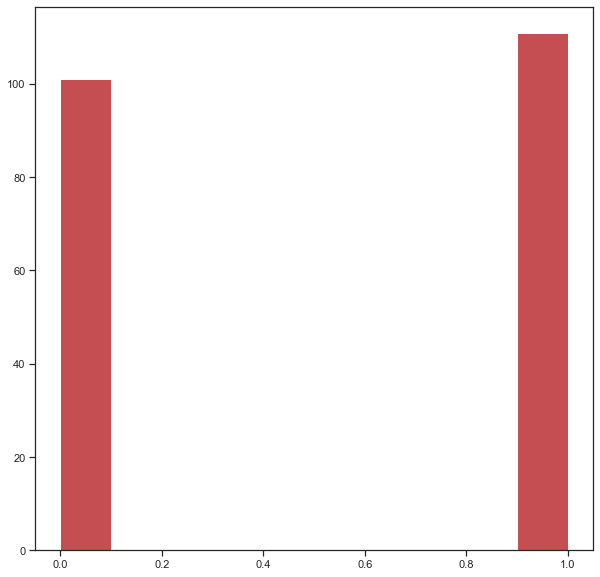

In [15]:
fig, ax = plt.subplots(figsize=(10,10)) 
plt.hist(train['target'], color="r")
plt.show()

**Оценим здесь же плотность вероятности распределения:**

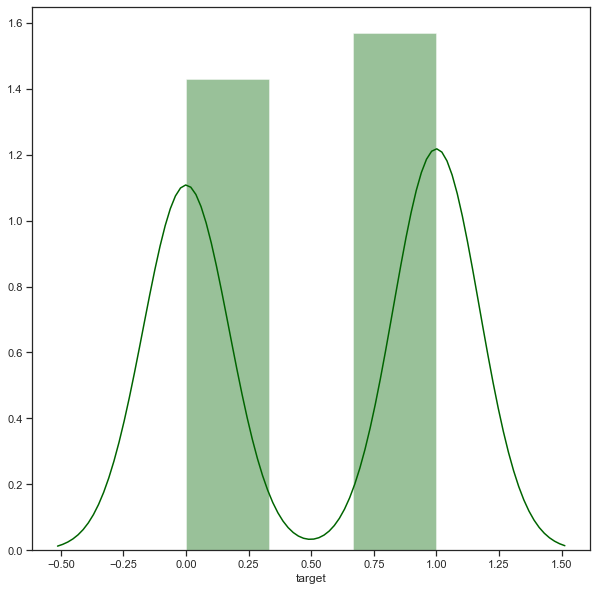

In [16]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(train['target'], color="darkgreen")

**Подсчитаем дисбаланс классов для обучающей выборки:**

In [17]:
total = train.shape[0]
class_0, class_1 = train['target'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 52.35999999999999%, а класс 1 составляет 47.64%.


In [18]:
train['target'].value_counts()

1    111
0    101
Name: target, dtype: int64

**Делаем вывод, что дисбаланс в обучающей выборке практически отсутствует.**

**Убедимся, что целевой признак для задачи бинарной классификации в тестовом датасете содержит только 0 и 1:**

In [19]:
test['target'].unique()

array([1, 0])

**Рассмотрим количество классов "0" и "1" целевого признака для задачи бинарной классификации в тестовом датасете:** 

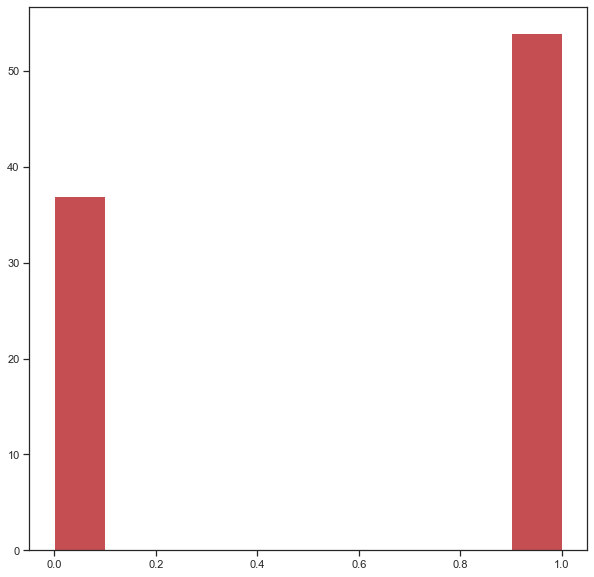

In [20]:
fig, ax = plt.subplots(figsize=(10,10)) 
plt.hist(test['target'], color="r")
plt.show()

**Оценим здесь же плотность вероятности распределения:**

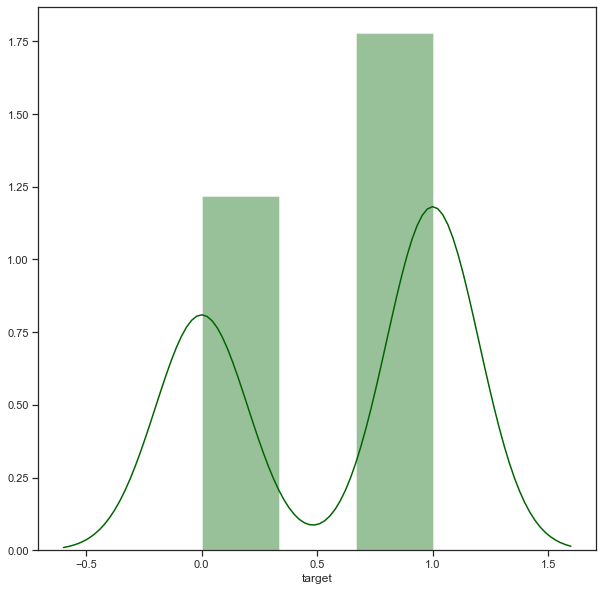

In [21]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(test['target'], color="darkgreen")

**Подсчитаем дисбаланс классов для обучающей выборки:**

In [22]:
total = test.shape[0]
class_0, class_1 = test['target'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 59.34%, а класс 1 составляет 40.660000000000004%.


In [23]:
test['target'].value_counts()

1    54
0    37
Name: target, dtype: int64

**Делаем вывод, что в тестовой выборке дисбаланс присутствует, но является приемлемым**

In [24]:
train.dtypes

age                  int64
gender               int64
chest_pain_type      int64
blood_pressure       int64
cholestoral          int64
sugar                int64
ECG                  int64
max_heart_rate       int64
stenocardia          int64
ST_depression      float64
slope                int64
vessels              int64
thal                 int64
target               int64
dtype: object

**Кодирование признаков не требуется, поскольку все данные представлены в числовом виде.**
**Для построения моделей будем использовать все признаки.**
**Объединим обучающую и тестовую выборки для масштабирования данных. Для начала создадим вспомогательные колонки для возможности дальнейшего разделения целого датасета:**

In [25]:
train['dataset'] = 'TRAIN'
test['dataset'] = 'TEST'

**Выберем столбцы для объединения датасетов:**

In [26]:
join_cols = ['age', 'gender', 'chest_pain_type', 'blood_pressure', 'cholestoral',
       'sugar', 'ECG', 'max_heart_rate', 'stenocardia', 'ST_depression',
       'slope', 'vessels', 'thal', 'target', 'dataset']

In [27]:
data_all = pd.concat([train[join_cols], test[join_cols]])

**Проверяем корректность объединения:**

In [28]:
assert data_all.shape[0] == train.shape[0]+test.shape[0]

In [29]:
data_all.head()

,age,gender,chest_pain_type,blood_pressure,cholestoral,sugar,ECG,max_heart_rate,stenocardia,ST_depression,slope,vessels,thal,target,dataset
0,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,TRAIN
1,54,1,2,125,273,0,0,152,0,0.5,0,1,2,1,TRAIN
2,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1,TRAIN
3,54,1,0,110,239,0,1,126,1,2.8,1,1,3,0,TRAIN
4,66,1,0,112,212,0,0,132,1,0.1,2,1,2,0,TRAIN


**Выберем столбцы для масштабирования:**

In [30]:
scale_cols = ['age', 'gender', 'chest_pain_type', 'blood_pressure', 'cholestoral', 'sugar', 'ECG', 'max_heart_rate', 'stenocardia', 'ST_depression', 'slope', 'vessels', 'thal', 'target']

In [31]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_all[scale_cols])

**Добавляем масштабированные данные в наш датасет:**

In [32]:
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_all[new_col_name] = sc1_data[:,i]

**Проверяем корректность:**

In [33]:
data_all.head()

,age,gender,chest_pain_type,blood_pressure,cholestoral,sugar,ECG,max_heart_rate,stenocardia,ST_depression,...,cholestoral_scaled,sugar_scaled,ECG_scaled,max_heart_rate_scaled,stenocardia_scaled,ST_depression_scaled,slope_scaled,vessels_scaled,thal_scaled,target_scaled
0,61,1,0,148,203,0,1,161,0,0.0,...,0.175799,0.0,0.5,0.687023,0.0,0.000000,1.0,0.25,1.000000,0.0
1,54,1,2,125,273,0,0,152,0,0.5,...,0.335616,0.0,0.0,0.618321,0.0,0.080645,0.0,0.25,0.666667,1.0
2,71,0,2,110,265,1,0,130,0,0.0,...,0.317352,1.0,0.0,0.450382,0.0,0.000000,1.0,0.25,0.666667,1.0
3,54,1,0,110,239,0,1,126,1,2.8,...,0.257991,0.0,0.5,0.419847,1.0,0.451613,0.5,0.25,1.000000,0.0
4,66,1,0,112,212,0,0,132,1,0.1,...,0.196347,0.0,0.0,0.465649,1.0,0.016129,1.0,0.25,0.666667,0.0


**Посмотрим, повлияло ли масштабирование на распределение данных:**

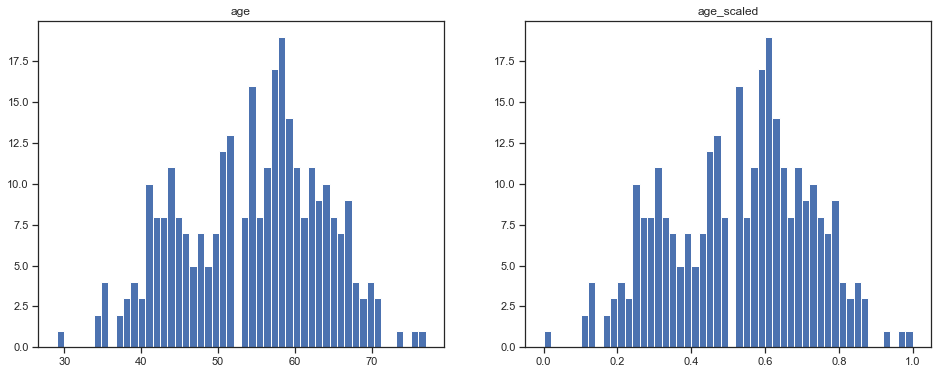

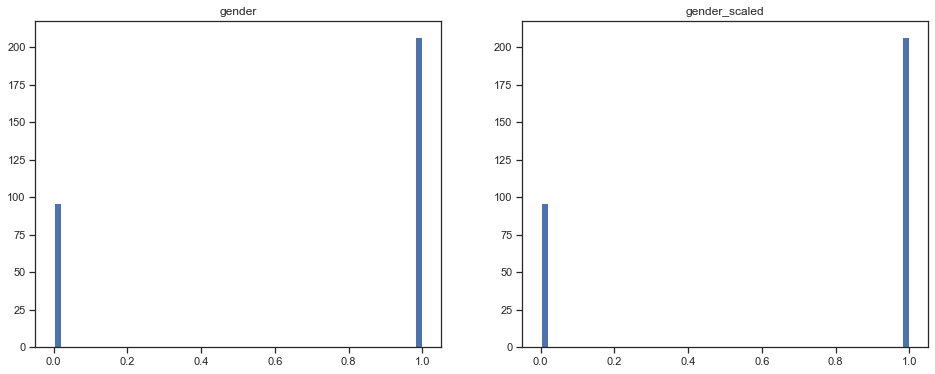

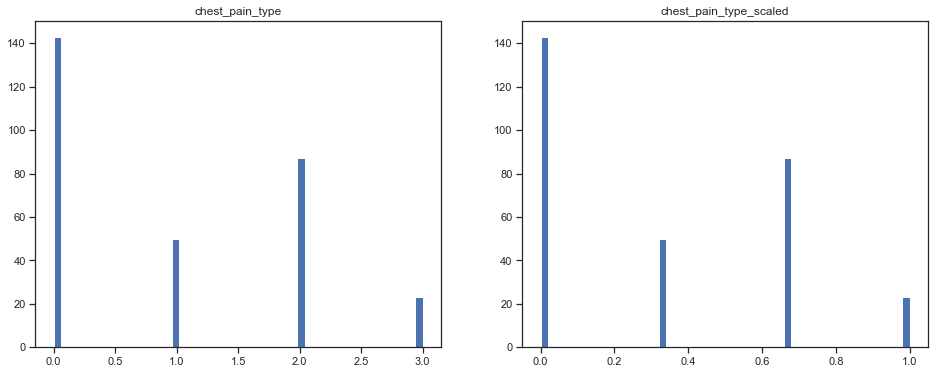

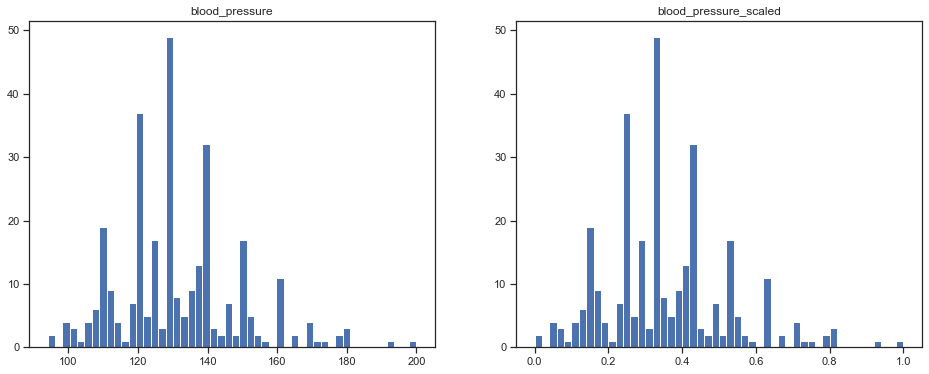

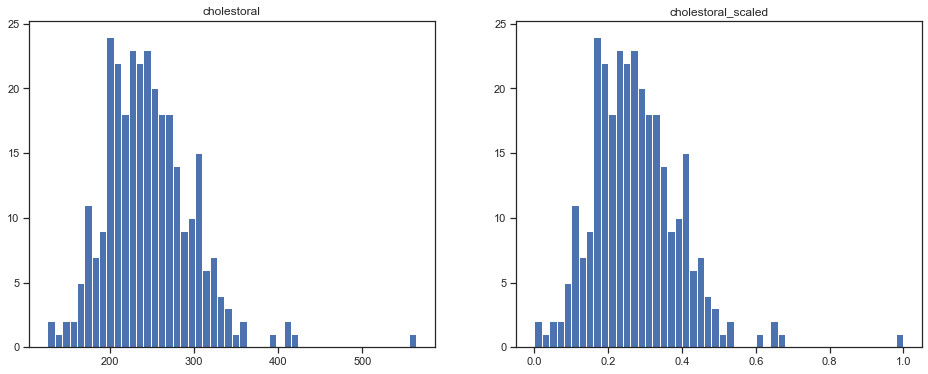

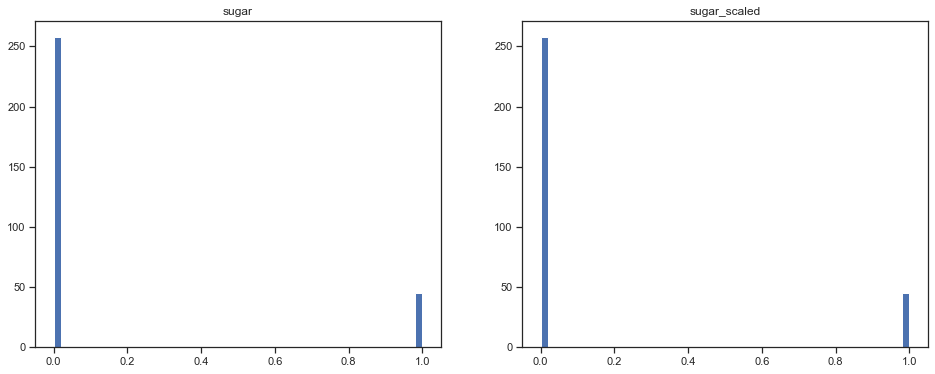

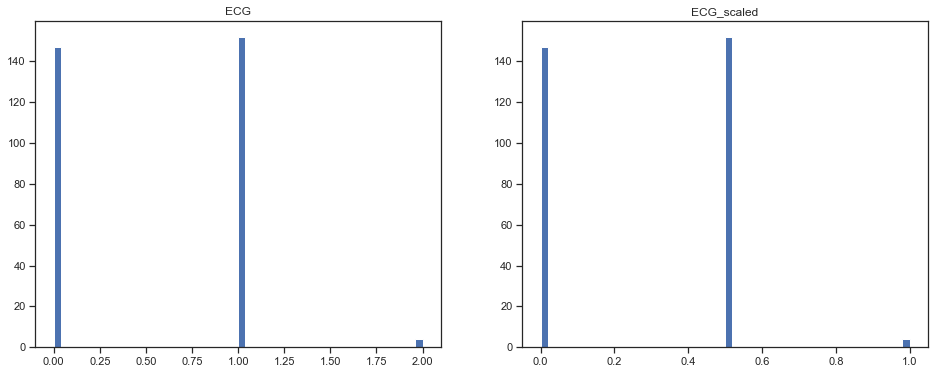

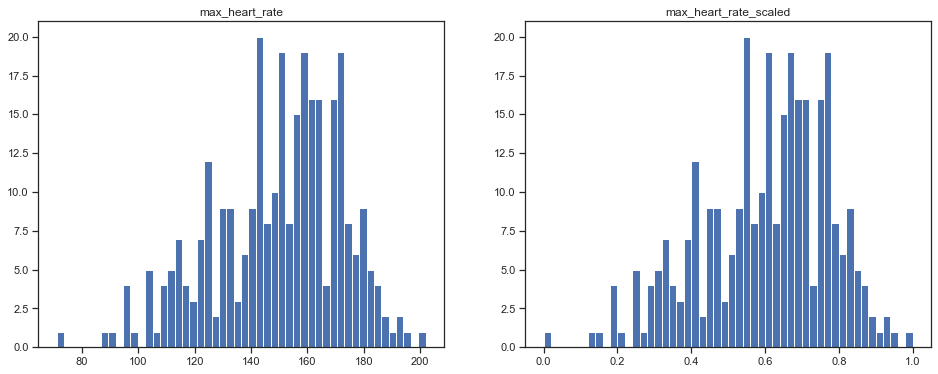

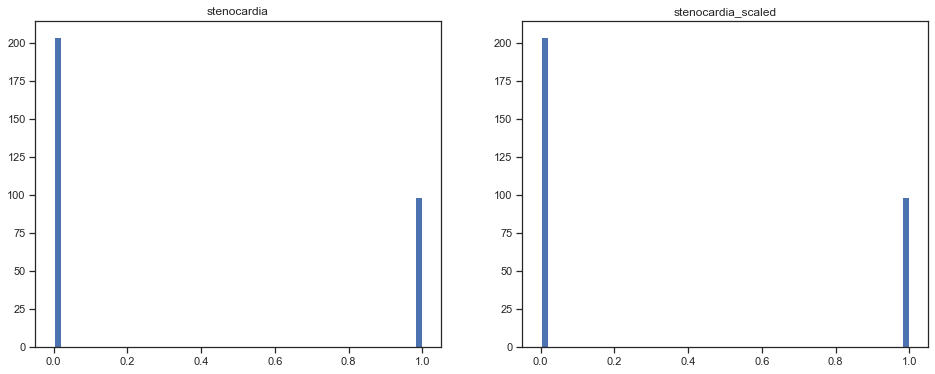

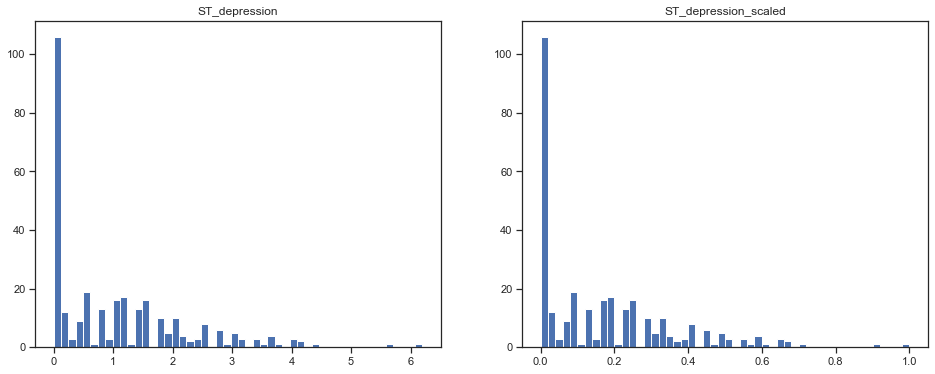

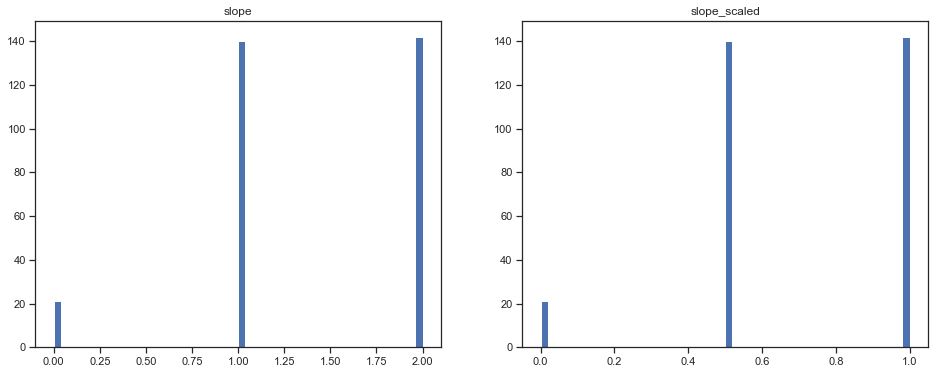

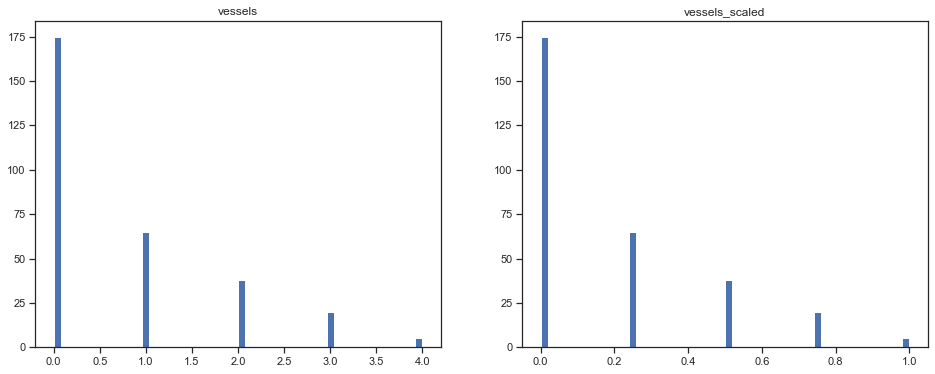

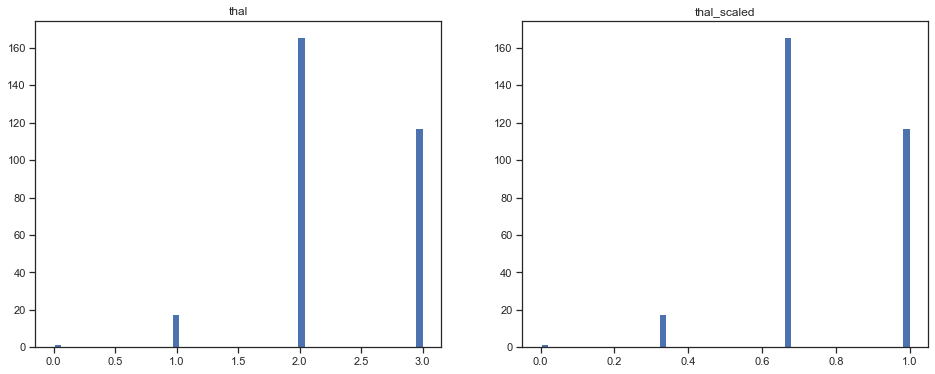

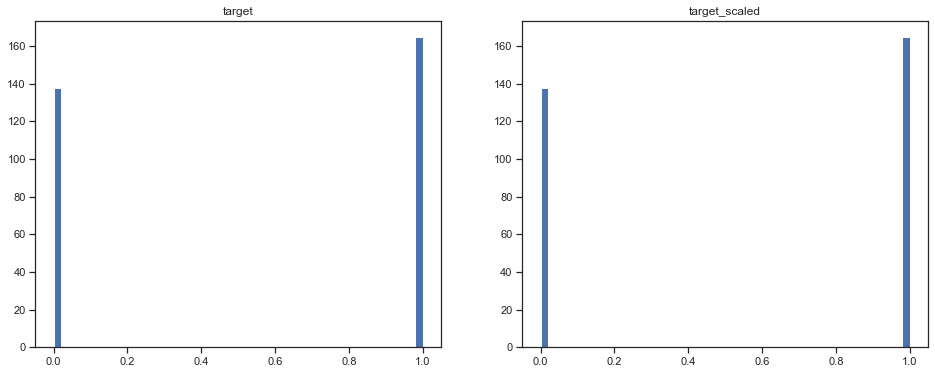

In [34]:
for col in scale_cols:
    col_scaled = col + '_scaled'
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    ax[0].hist(data_all[col], 50)
    ax[1].hist(data_all[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

**Выводы: масштабирование данных не повлияло на их распределение**

**Включим тестовую выборку в корреляционную матрицу:**

In [35]:
corr_cols_1 = scale_cols + ['target']
corr_cols_1

['age',
 'gender',
 'chest_pain_type',
 'blood_pressure',
 'cholestoral',
 'sugar',
 'ECG',
 'max_heart_rate',
 'stenocardia',
 'ST_depression',
 'slope',
 'vessels',
 'thal',
 'target',
 'target']

In [36]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['target']
corr_cols_2

['age_scaled',
 'gender_scaled',
 'chest_pain_type_scaled',
 'blood_pressure_scaled',
 'cholestoral_scaled',
 'sugar_scaled',
 'ECG_scaled',
 'max_heart_rate_scaled',
 'stenocardia_scaled',
 'ST_depression_scaled',
 'slope_scaled',
 'vessels_scaled',
 'thal_scaled',
 'target_scaled',
 'target']

**Построим корреляционную матрицу:** 

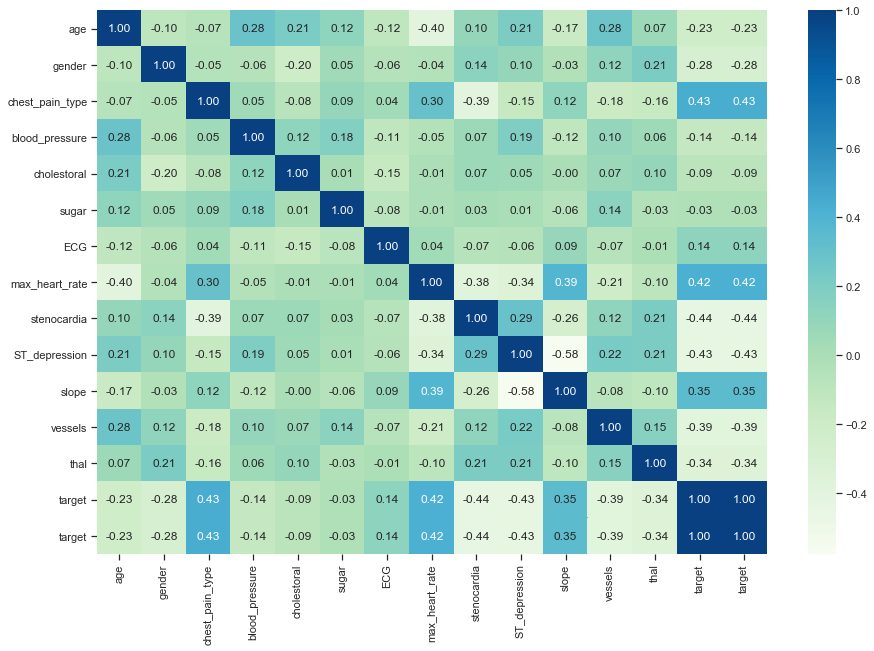

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_all[corr_cols_1].corr(), annot=True, fmt='.2f', cmap='GnBu')

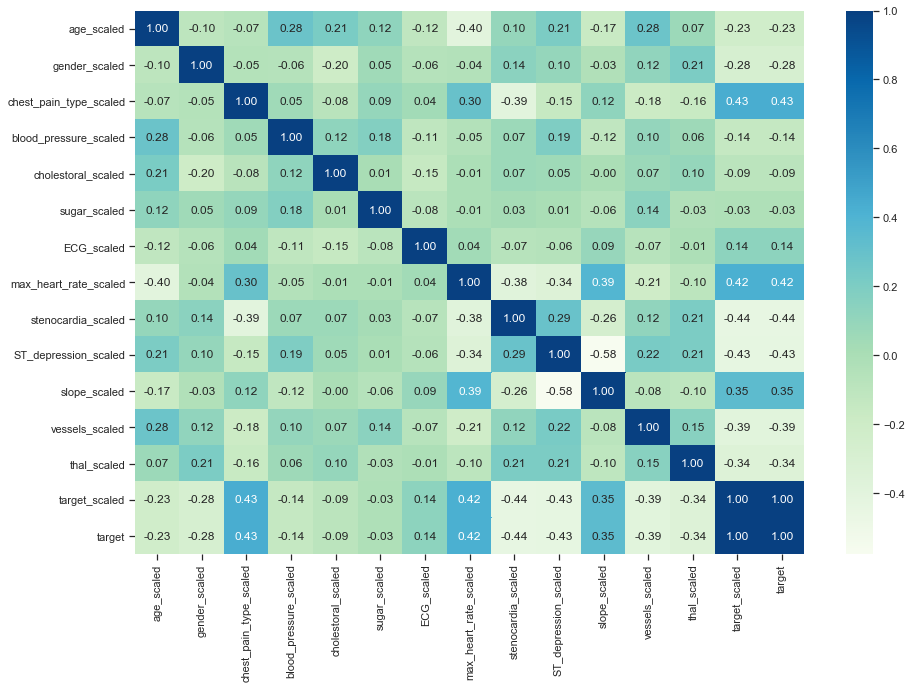

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_all[corr_cols_2].corr(), annot=True, fmt='.2f', cmap="GnBu")

**Корреляционные матрицы для исходных и масштабированных данных полностью совпадают.**

**Целевой признак решения задачи классификации target наиболее коррелирует с (по убыванию): stenocardia, ST_depression, chest_pain_type, max_heart_rate, vessels, slope, thal и gender. Признак max_heart_rate коррелирует с большей частью остальных выше перечисленных признаков. Поэтому в модель классификации войдут все выше перечисленные признаки за исключением max_heart_rate.**

## 4) Выбор метрик для последующей оценки качества моделей.

**В качестве метрик для решения задачи классификации  будем использовать:**
- Метрика precision: $precision = \frac{TP}{TP+FP}$
- Метрика recall (полнота): $recall = \frac{TP}{TP+FN}$
- Метрика $F_1$-мера: $F_\beta = (1+\beta^2) \cdot \frac{precision \cdot recall}{precision + recall}$, где $\beta$ определяет вес точности в метрике.
- Метрика ROC AUC: $TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall. $FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

**Введем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества:**

In [39]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

## 5) Формирование обучающей и тестовой выборок на основе исходного набора данных.
**Выделим обучающую и тестовую выборки на основе масштабированных данных с помощью фильтра:**

In [40]:
train_data_all = data_all[data_all['dataset']=='TRAIN']
test_data_all = data_all[data_all['dataset']=='TEST']
train_data_all.shape, test_data_all.shape

((212, 29), (91, 29))

**Определим признаки для задачи классификации:**

In [41]:
task_clas_cols = ['stenocardia', 'gender', 'slope', 'ST_depression', 'chest_pain_type', 'vessels', 'thal']

**Определим выборки для задачи классификации:**

In [42]:
clas_X_train = train_data_all[task_clas_cols]
clas_X_test = test_data_all[task_clas_cols]
clas_Y_train = train_data_all['target']
clas_Y_test = test_data_all['target']
clas_X_train.shape, clas_X_test.shape, clas_Y_train.shape, clas_Y_test.shape

((212, 7), (91, 7), (212,), (91,))

## 6) Построение базового решения 


**Определим модели:**

In [43]:
clas_models = {'LogR': LogisticRegression(),
               'SVC':SVC(),
               'Tree':DecisionTreeClassifier()}

**Сохранение метрик:**

In [44]:
clasMetricLogger = MetricLogger()

In [45]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y_train)
    Y_pred = model.predict(clas_X_test)
    precision = precision_score(clas_Y_test.values, Y_pred)
    recall = recall_score(clas_Y_test.values, Y_pred)
    f1 = f1_score(clas_Y_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y_test.values, Y_pred)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    print('*****************************************************')
    print(model)
    print('*****************************************************')
    draw_roc_curve(clas_Y_test.values, Y_pred)
    
    plot_confusion_matrix(model, clas_X_test, clas_Y_test.values, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

*****************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
*****************************************************


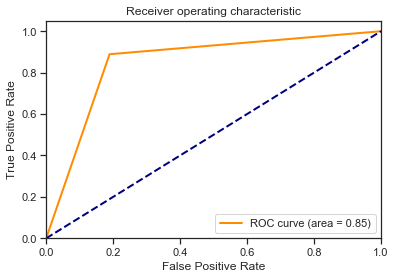

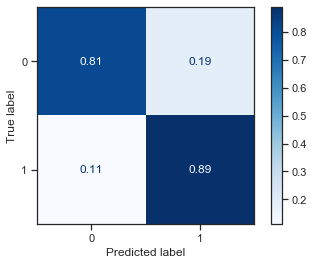

*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
*****************************************************


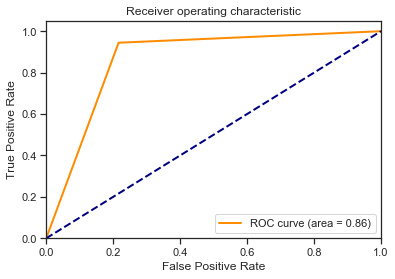

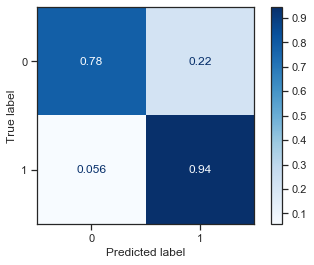

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
*****************************************************


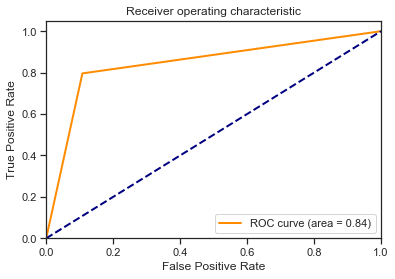

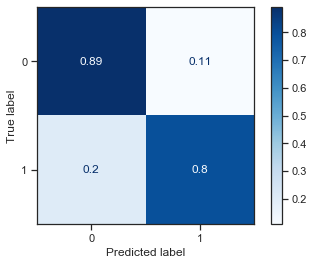

In [46]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

## 7) Подбор гиперпараметров 

In [47]:
clas_X_train.shape

(212, 7)

In [48]:
n_range = np.array(range(1,170,3))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
          40,  43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,
          79,  82,  85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115,
         118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154,
         157, 160, 163, 166, 169])}]

In [49]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(clas_X_train, clas_Y_train)

CPU times: user 3.71 s, sys: 109 ms, total: 3.82 s
Wall time: 1.52 s


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
        40,  43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,
        79,  82,  85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115,
       118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154,
       157, 160, 163, 166, 169])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

**Лучшая модель:**

In [50]:
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

**Лучшее значение параметров:**

In [51]:
clf_gs.best_params_

{'n_neighbors': 25}

**Изменение качества на тестовой выборке в зависимости от К-соседей:**

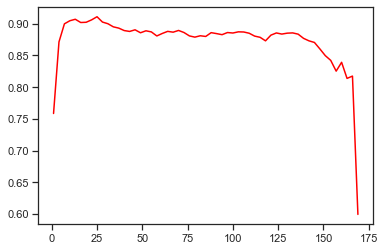

In [52]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'], color="red")

## 8) Сравнение качества полученных моделей с качеством baseline-моделей.


In [53]:
clas_models_grid = {'KNN_25':clf_gs.best_estimator_}

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')
*****************************************************


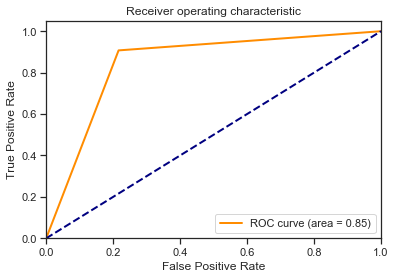

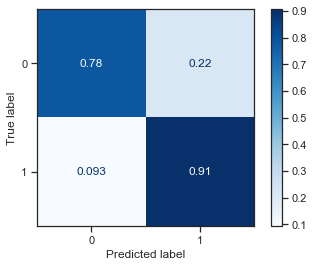

In [54]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

## 9) Формирование выводов о качестве построенных моделей на основе выбранных метрик


**Метрики качества модели:**

In [55]:
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

**Графики метрик качества модели:**

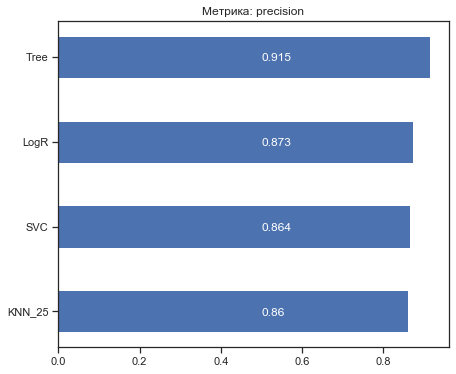

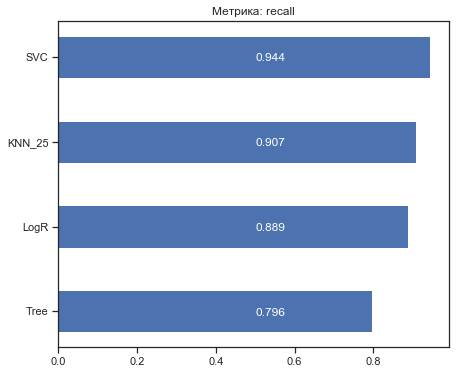

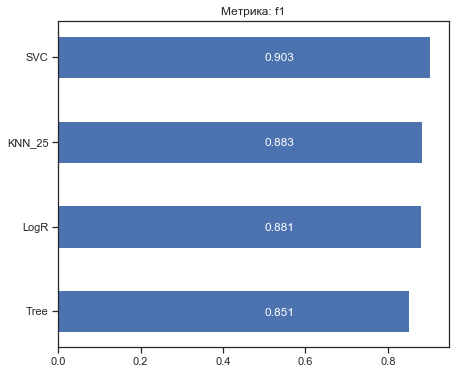

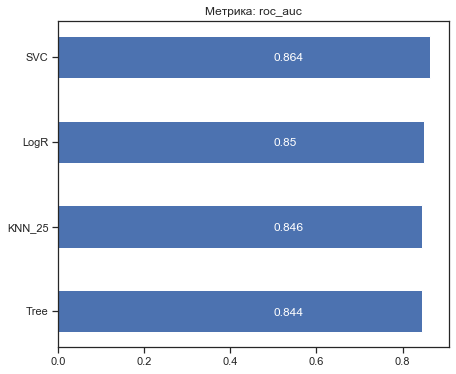

In [56]:
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

**Выводы: гиперпараметры подобраны далеко не самым лучшим образом, можно лучше**